In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC, LargeAxialLBC
import torch
from src.datasets.floe import DatasetFloe_Ice_Mask, DatasetValidateFloe, DatasetTestFloe
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F
import matplotlib
from src.models.mobilenets import lraspp_mobilenet_v3_large_one_channel

In [2]:
latex = True
#plotting and colour set ups
if latex:
#     matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
#         'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [12]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str, img_number, mobile: bool = False) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[img_number]['image'][0, :, :].unsqueeze(0).to(device=device).unsqueeze(0)
    mask = val_set[img_number]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

    if mobile:
        imgs = torch.stack([img, img], dim=0).squeeze(1)
        with torch.no_grad():
            output = model(imgs)['out']
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)[0].unsqueeze(0)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output[0].unsqueeze(0), mask.squeeze(1)).detach().item()
    else:
        with torch.no_grad():
            output = model(img)
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    return img_np, mask_np, argmx_np

In [27]:
def plot_example(ax, img, is_img=False, x_label=None, y_label=None):
    ax.imshow(img)#, cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
#     ax.axis('off')
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label) # , rotation=0)
    
def plot_column(ind, img_number, epoch=10):
    x_label, y_label = None, None
    img, mask, pred = eval_model(
        UNet(n_channels=1, n_classes=2, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/glowing_armadillo_326_unet_floe/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Image'
    plot_example(axs[0, ind], img, x_label=x_label, y_label=y_label)
    if img_number==0:
        y_label = 'Ground Truth'
    plot_example(axs[1, ind], mask, x_label=x_label, y_label=y_label)
    if img_number==0:
        y_label = 'Full UNet'
    plot_example(axs[2, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        UNetDSC(n_channels=1, n_classes=2, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/smart_silence_327_dsc_unet_floe/epoch{epoch}.pth', 
        'DSC UNet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Full DSC UNet'
    plot_example(axs[3, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        UNetLBP(1, 2).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/royal_darkness_330_lbc_unet_floe/epoch{epoch}.pth', 
        'LBC Unet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Full LBC UNet'
    plot_example(axs[4, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        DSCUNetLBP(1, 2).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/gentle_yogurt_328_dsc_unet_lbp_floe/epoch{epoch}.pth', 
        'DSC LBC UNet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Full DSC LBC UNet'
    plot_example(axs[5, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SmallUNet(n_channels=1, n_classes=2, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/playful_snowball_331_small_unet_floe/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Small UNet'
    plot_example(axs[6, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
         SmallUNetDSC(n_channels=1, n_classes=2, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/polar_shadow_332_small_dsc_unet_floe/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Small DSC UNet'
    plot_example(axs[7, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SmallUNetLBP(1, 2).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/elated_violet_333_small_lbc_unet_floe/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Small LBC UNet'
    plot_example(axs[8, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        DSCSmallUNetLBP(1, 2).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/dulcet_meadow_329_dsc_lbc_small_unet_floe/epoch{epoch}.pth', 
        'DSC LBC Small UNet, 80 epochs', img_number
    )
    if img_number==0:
        y_label = 'Small DSC LBC UNet'
    plot_example(axs[9, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        lraspp_mobilenet_v3_large_one_channel.to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/vocal_brook_343_lraspp_floe/epoch{epoch}.pth', 
        'LRASPP MobileNet, 80 epochs', img_number,
        mobile=True
    )
    if img_number==0:
        y_label = 'MobileNetV3 (LR-ASPP)'
    plot_example(axs[10, ind], pred, x_label=x_label, y_label=y_label)

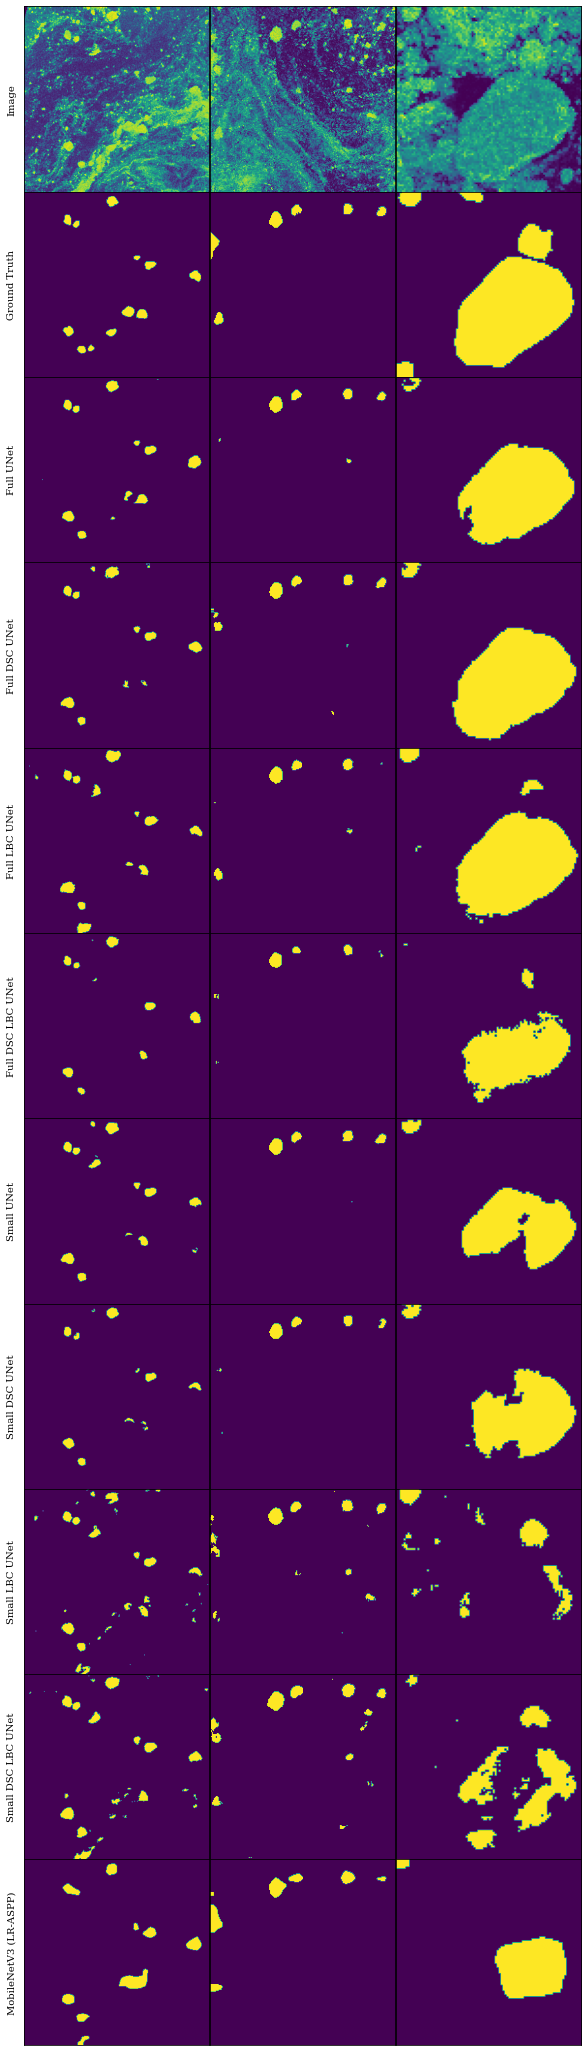

In [28]:
fig, axs = plt.subplots(11,3, figsize=(10, 37.5))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_set = DatasetValidateFloe()

plot_column(0, 0)
plot_column(1, 7)
plot_column(2, 1)
fig.subplots_adjust(wspace=0, hspace=0)

In [6]:
# fig.savefig("../images/pred_results_v3.svg", format='svg', dpi=1200)